In [2]:
import pandas as pd
import classy as Class
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)
print(As)

standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    #"100*theta_s": 1.04,
    "H0": 67.66
}

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 1,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                  }

#LCDM parameters
for name, value in standard_params.items():
    common_settings.update({name: value})

pr_cover_tau = 0.004
precision_settings = {"start_sources_at_tau_c_over_tau_h": pr_cover_tau}

M = Class.Class()
M.set(common_settings)
M.set(precision_settings)

2.105209331337507e-09


True

In [3]:
M.compute()

fiducial_thermo = M.get_thermodynamics()
fiducial = fiducial_thermo["x_fid"]

Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690267


In [4]:
def create_pivot_redshifts(N, start, stop):
    pivots = np.linspace(start=start, stop=stop, num=N+2)
    free_pivots = pivots[1:-1]

    str_pivots = ["{:.4f}".format(p) for p in pivots]
    str_pivots = ",".join(str_pivots)

    return [pivots, free_pivots, str_pivots]

num_control_points = 8
zmin_pert = 800
zmax_pert = 1700

pivot_info = create_pivot_redshifts(num_control_points, zmin_pert, zmax_pert)

print(pivot_info[2])

800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000,1500.0000,1600.0000,1700.0000


In [5]:
def load_minima(fname):
    df = pd.read_csv(fname)
    ncol = len(df.columns)
    ncp = ncol-18 #change if new likelihoods introduced
    cp_labels = []
    for i in np.arange(1,ncp+1):
        cp_labels.append("q_{}".format(i))
    col = ['weight', 'minuslogpost', 'logA', 'n_s', 'omega_b', 'omega_cdm', 'tau_reio', *cp_labels, 'A_planck', 'clamp', 'chi2__CMB', 'minuslogprior', 'minuslogprior__0', 'minuslogprior__control_point_joint_prior', 'chi2', 'chi2__planck_2018_lowl.TT', 'chi2__planck_2018_lowl.EE', 'chi2__planck_2018_highl_plik.TTTEEE_lite', 'h']
    vals = list(df.columns)
    df.columns = col
    def quick_util(x):
        try:
            return float(x)
        except ValueError:
            pass
    df.loc[-1] = [quick_util(x) for x in vals]
    df.index = df.index+1
    df = df.sort_values(by=['h'], ascending=True)
    return df

In [6]:
df1 = load_minima("/Users/gabe/projects/recombination/data/nldr_result_h73.csv")
df2 = load_minima("/Users/gabe/projects/recombination/data/nldr_result_h73_2.csv")
df3 = load_minima("/Users/gabe/projects/recombination/data/nldr_result_h73_more.csv")

In [7]:
def get_thermo(df, zmin_pert, zmax_pert):
    common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control'}
    
    thermos={}
    cp_labels = []

    for name in df.columns:
        if re.match(r"q_[0-9]{1,3}", name):
            cp_labels.append(name)

    N = len(cp_labels)
    pivot_info = create_pivot_redshifts(N, zmin_pert, zmax_pert)

    for index,row in df.iterrows():
        cps = [0.0]
        for name in cp_labels:
            cps.append(row[name])
        cps.append(0.0)
        cps_str = ",".join([str(c) for c in cps])
        params = {
        "omega_b": row["omega_b"],
        "omega_cdm": row["omega_cdm"],
        "n_s": row["n_s"],
        "tau_reio": row["tau_reio"],
        "ln10^{10}A_s": row["logA"],
        #"100*theta_s": 1.04,
        "H0": 100*row["h"],
        "xe_control_points": cps_str
        }
        pert_settings = {'xe_pert_num': N+2,
                         'zmin_pert': zmin_pert,
                         'zmax_pert': zmax_pert,
                         'xe_control_pivots': pivot_info[2]
                        }
        common_settings.update(params)
        common_settings.update(pert_settings)
        M.set(common_settings)
        M.compute(level=["thermodynamics"])
        thermos[row["h"]] = M.get_thermodynamics()
    return thermos

t1 = get_thermo(df1, zmin_pert=zmin_pert, zmax_pert=zmax_pert)


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_96008/2419579300.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


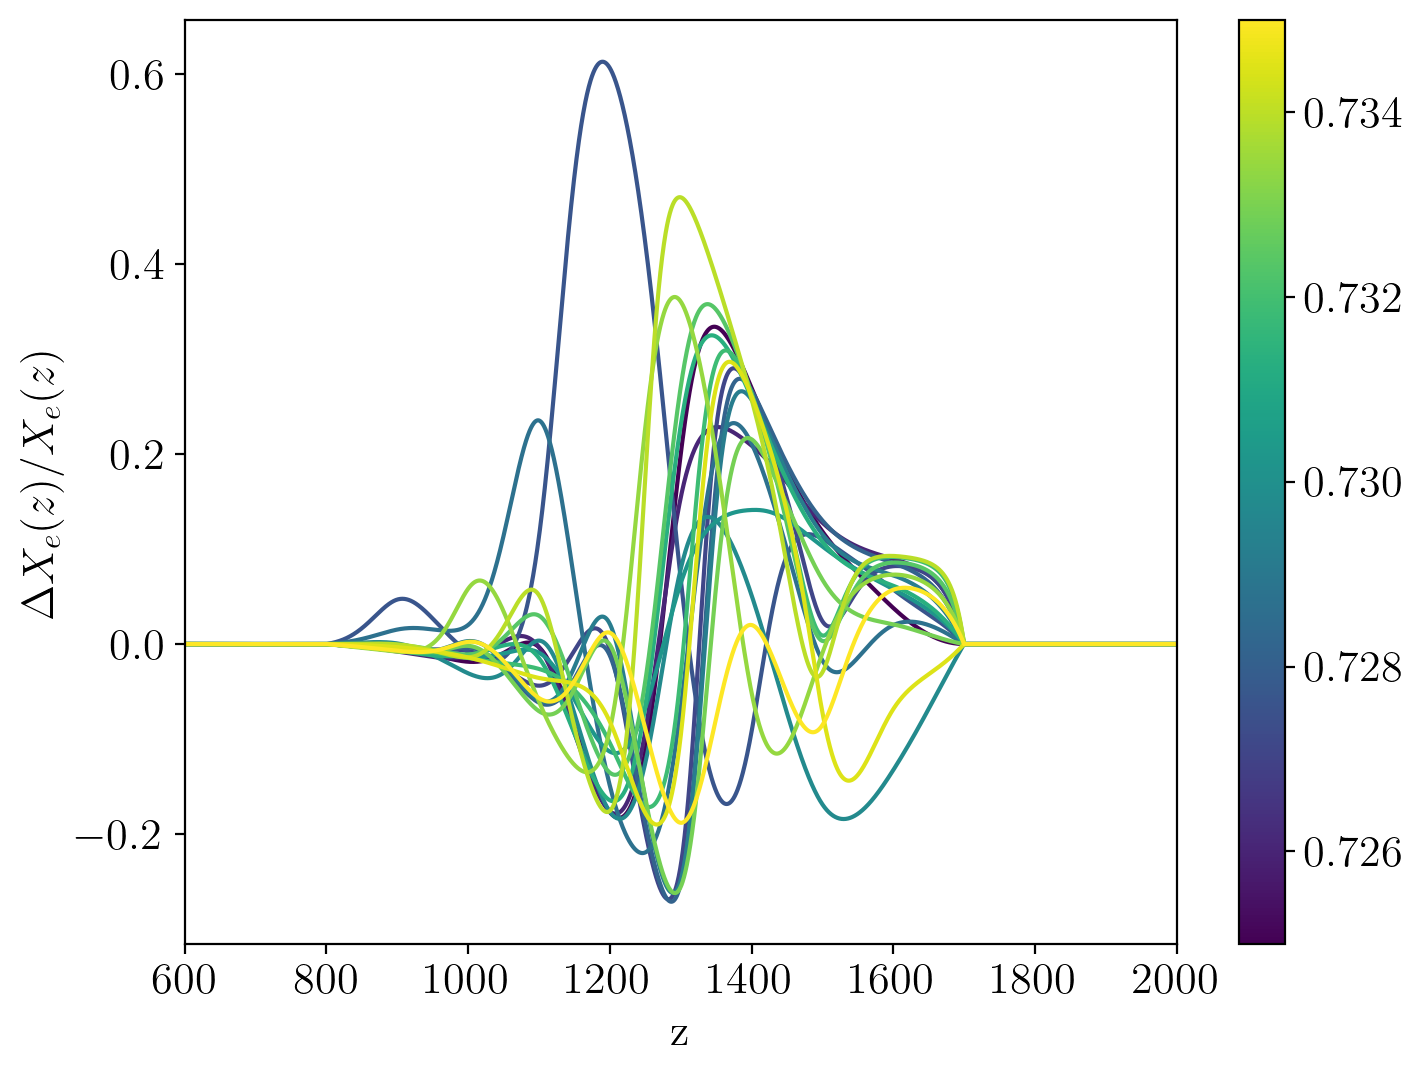

In [8]:
fig,ax = plt.subplots()

H0s = np.array([float(x) for x in t1.keys()])

norm = mpl.colors.Normalize(vmin=H0s.min(), vmax=H0s.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for h,thermo in t1.items():
    ax.plot(thermo["z"], thermo["xe_pert"], color=cmap.to_rgba(h))
    
ax.set_xlim([600, 2000])
ax.set_xlabel("z")
ax.set_ylabel(r"$\Delta X_e(z) / X_e(z)$")
fig.colorbar(cmap)
plt.show()
#plt.savefig("../results/nldr_h73_1.pdf", dpi=300, bbox_inches='tight')

/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_96008/595394775.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


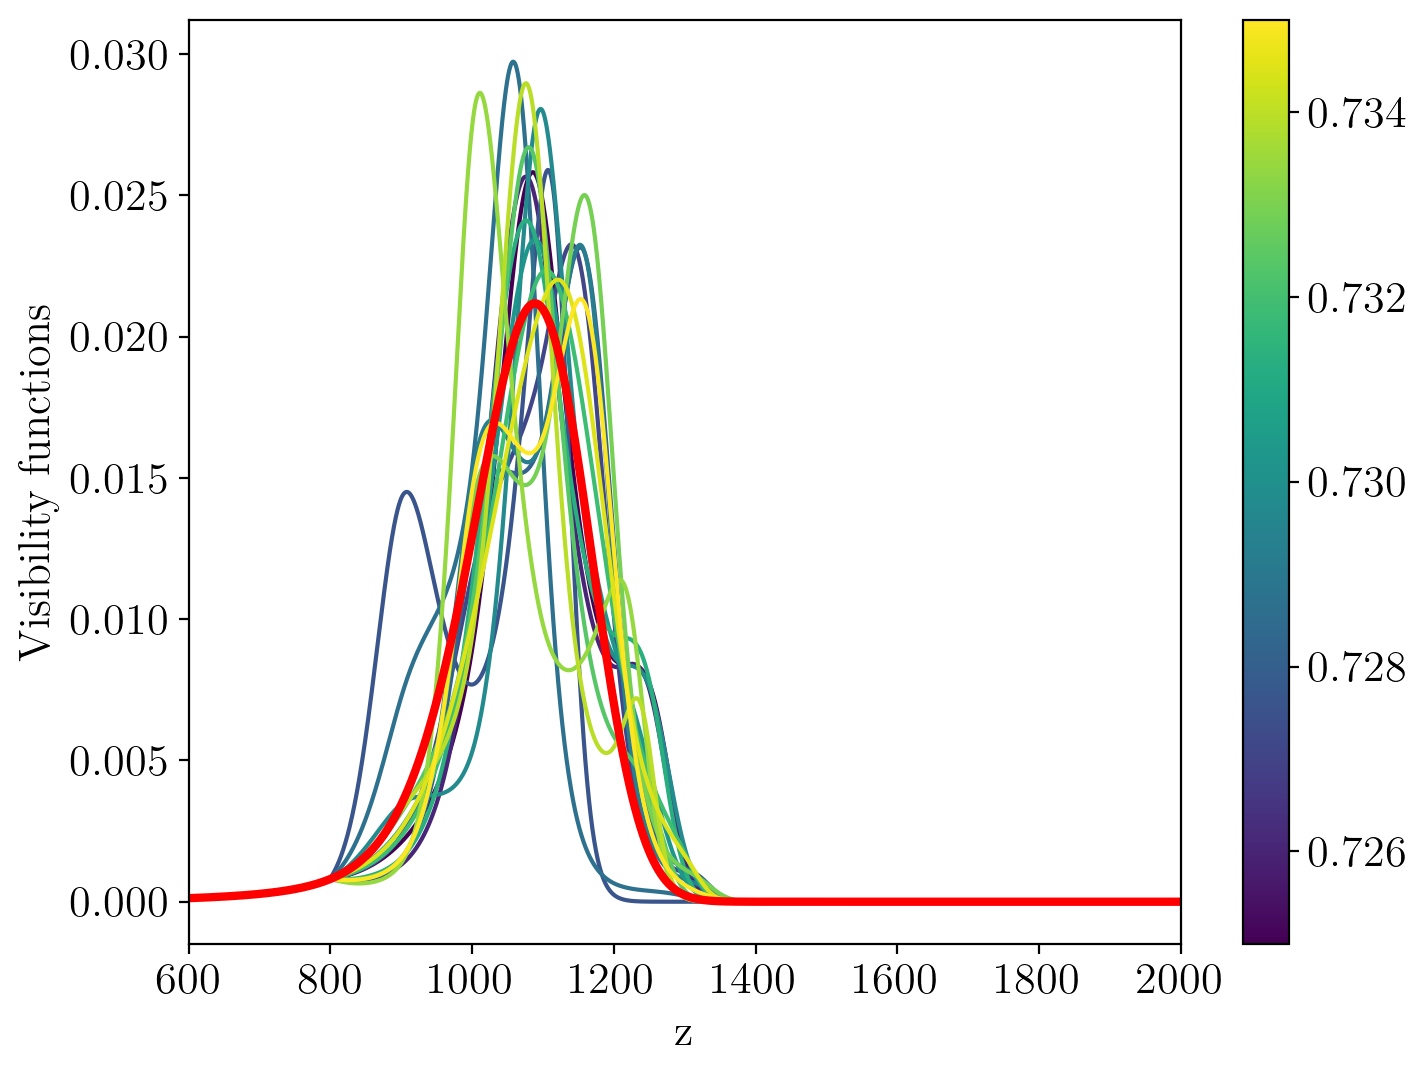

In [9]:
fig,ax = plt.subplots()

for h,thermo in t1.items():
    ax.plot(thermo["z"], thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"], color=cmap.to_rgba(h))
ax.plot(fiducial_thermo["z"], fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"], color="red", linewidth=3)
ax.set_xlim([600, 2000])
ax.set_xlabel("z")
ax.set_ylabel("Visibility functions")
fig.colorbar(cmap)
plt.show()
#plt.savefig("../results/nldr_viz_h73_1.pdf", dpi=300, bbox_inches='tight')

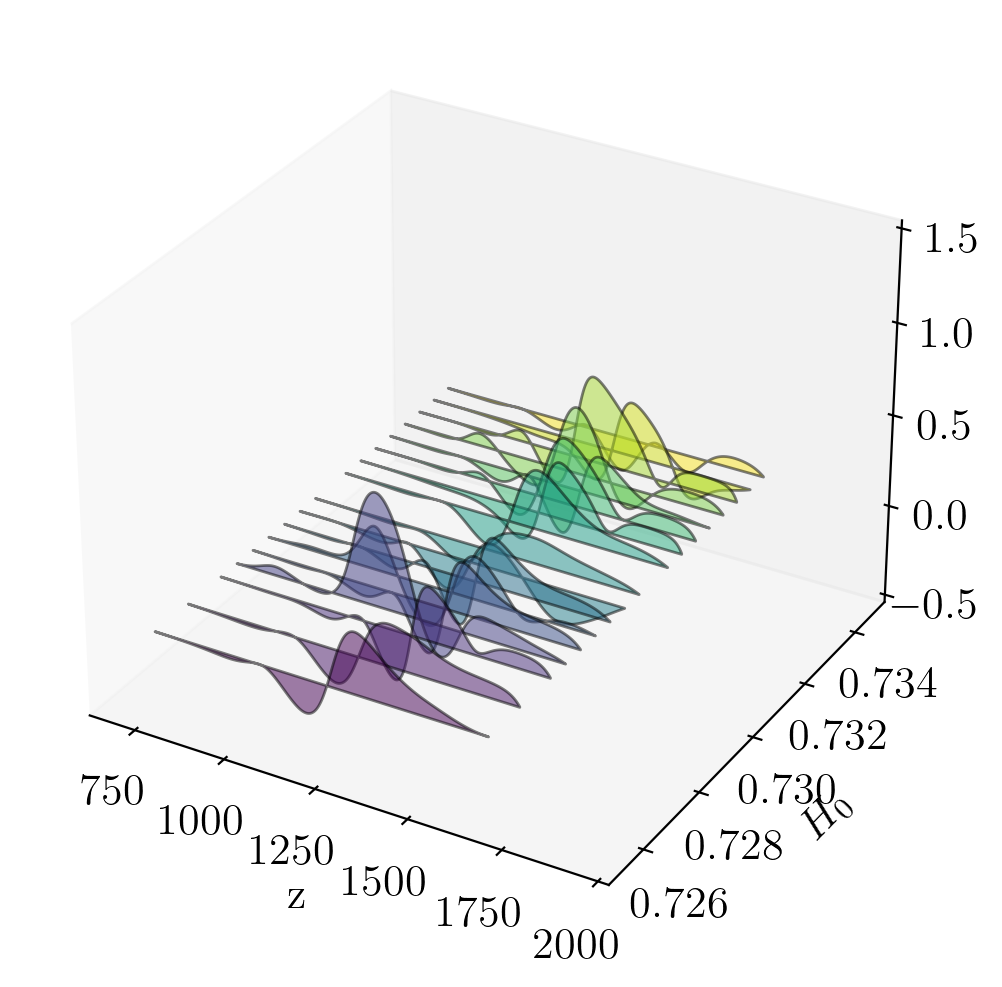

In [10]:
from matplotlib.collections import PolyCollection
import math

# Fixing random state for reproducibility
ax = plt.figure().add_subplot(projection='3d')
a = 0

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0), *zip(x, y), (x[-1], 0)]

z_list = t1[0.725]["z"]

test = np.where(z_list<zmin_pert, 1, 0)
ind_lowz = np.argwhere(np.diff(test)==-1)[0][0]
test = np.where(z_list>zmax_pert, 1, 0)
ind_hiz = np.argwhere(np.diff(test)==1)[0][0]
# verts[i] is a list of (x, y) pairs defining polygon i.
verts=[]
for h,thermo in t1.items():
    verts.append(polygon_under_graph(z_list[ind_lowz:ind_hiz], thermo["xe_pert"][ind_lowz:ind_hiz]))

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

#poly = PolyCollection(verts,facecolor='white', alpha=0.5)
poly = PolyCollection(verts,facecolor=facecolors[::-1], alpha=0.5)
poly.set_edgecolor('black')
ax.add_collection3d(poly, zs=H0s[a:], zdir='y')

ax.set(xlim=(650, 2000), zlim=(-0.5, 1.5), ylim=(H0s.min(), H0s.max()),
       xlabel='z', ylabel=r'$H_0$', zlabel='')
ax.grid(False)
plt.show()
#plt.savefig("../results/nldr_depth_h73_1.pdf", dpi=300, bbox_inches='tight')

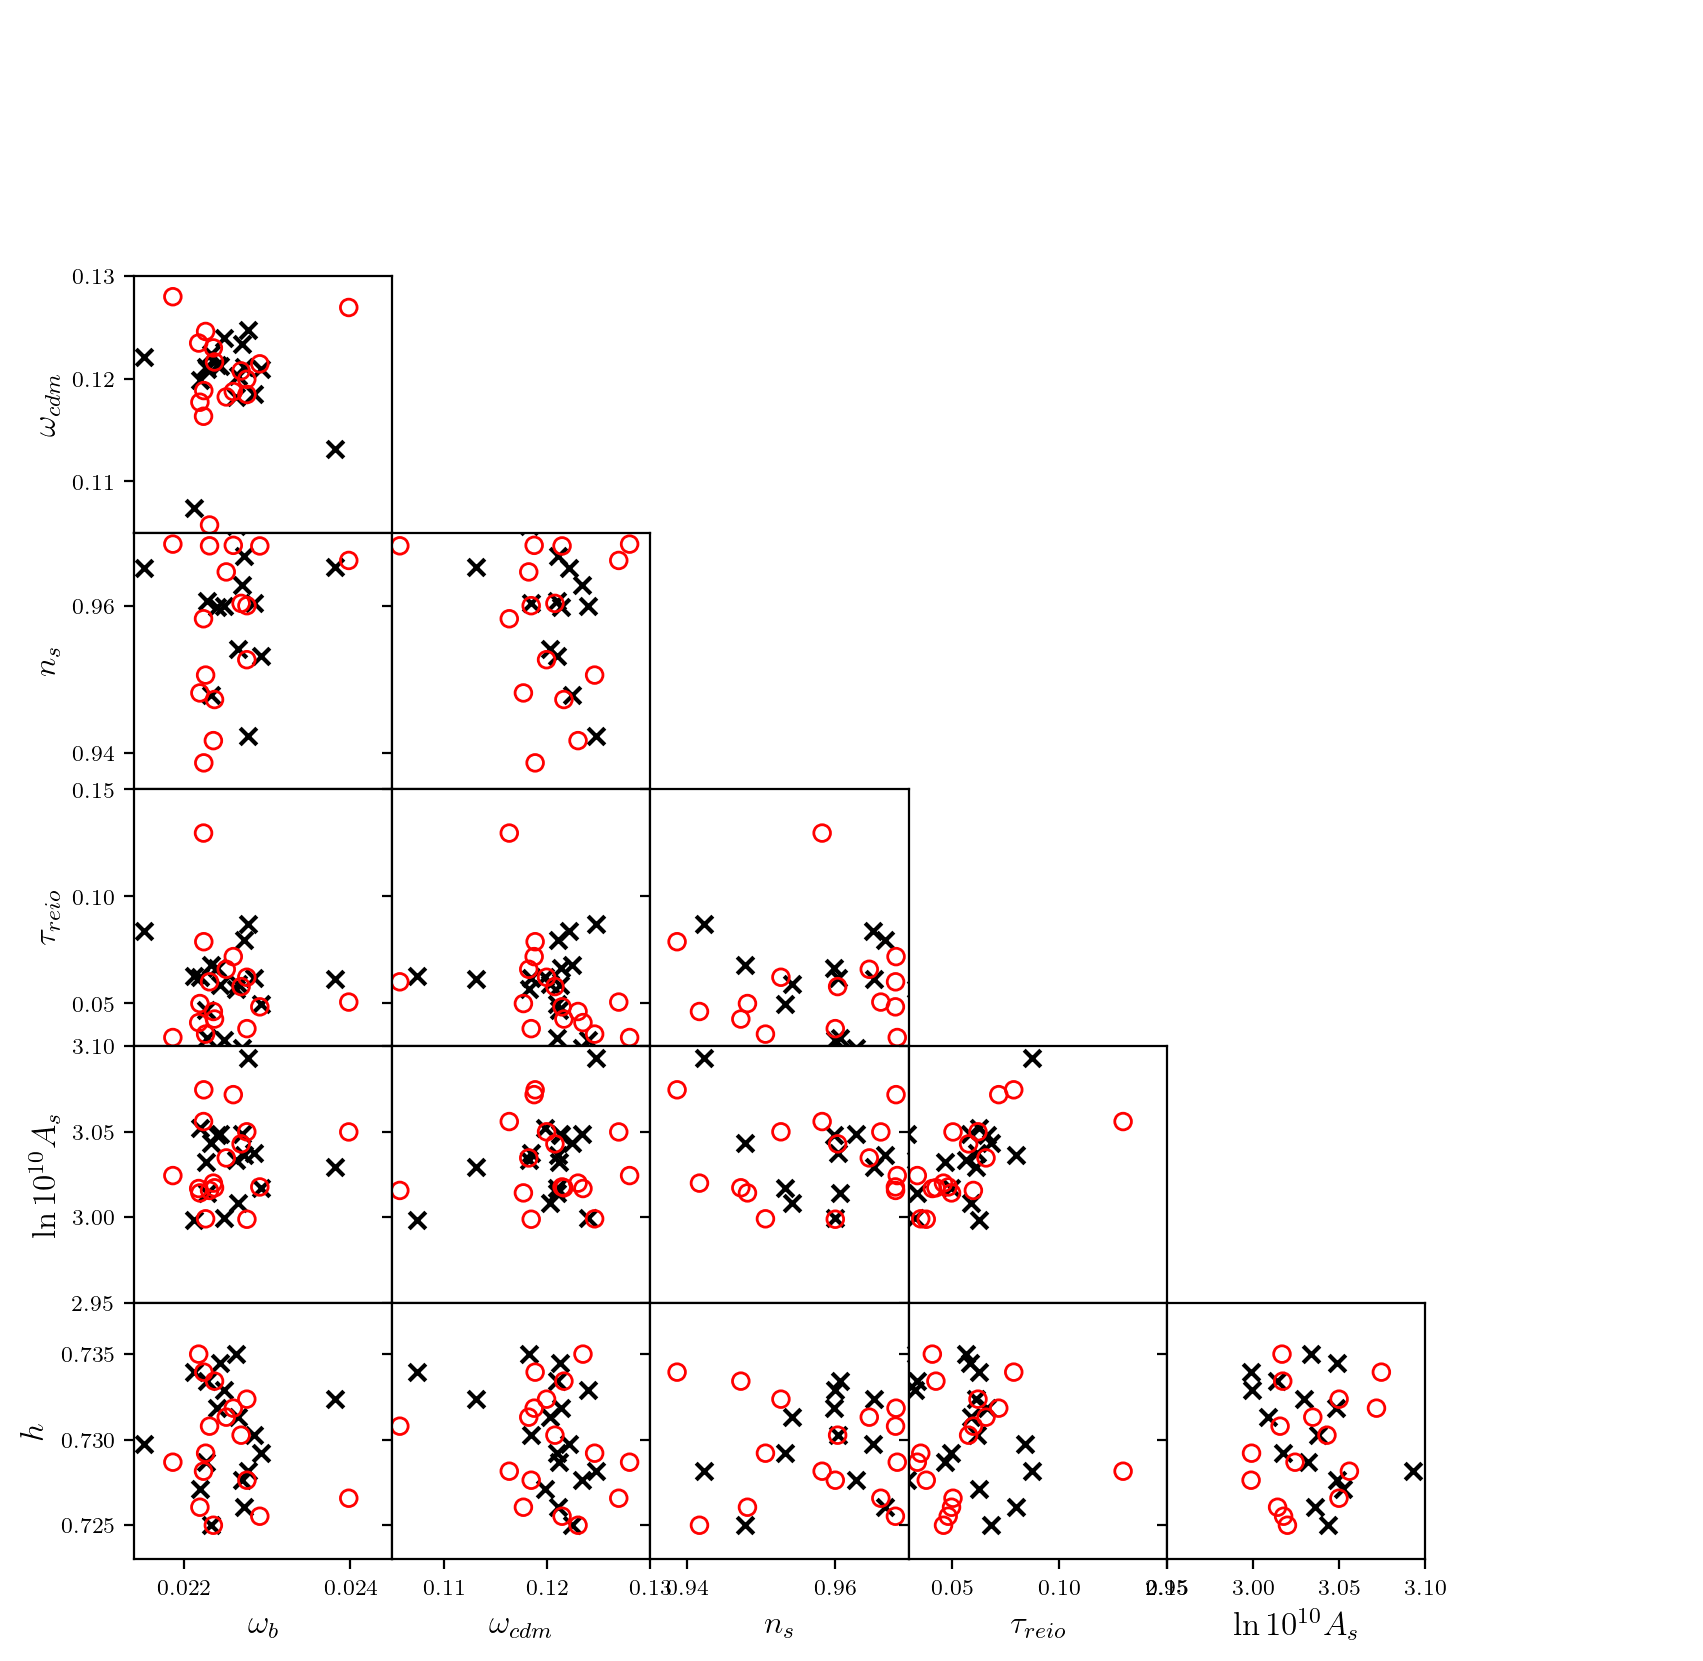

In [11]:
fig,ax = plt.subplots(6,6, figsize=(10,10), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
params_to_plot = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'logA', 'h']

def plot_standard_cosmo(ax, df, params_to_plot, marker="x", color_choice="auto", targets=[], tc="green"):

    n = len(params_to_plot)
    for i in range(n):
        for j in range(n):
            if(i<=j):
                ax[i,j].axis('off')
                continue
            #ax[i,j].text(0.1, 0.5, "({}, {})".format(params_to_plot[i], params_to_plot[j]), size=8)

    for index,row in df.iterrows():
        for i in range(n):
            for j in range(n):
                if(i<=j):
                    continue
                if(color_choice=="auto"):
                    c=cmap.to_rgba(100*float(row["h"]))
                elif(float(row["h"]) in targets):
                    c=tc
                else:
                    c=color_choice
                if marker=="o":
                    ax[i,j].scatter(float(row[params_to_plot[j]]), float(row[params_to_plot[i]]) , marker=marker, facecolors="none", edgecolors=c)
                else:
                    ax[i,j].scatter(float(row[params_to_plot[j]]), float(row[params_to_plot[i]]) , marker=marker, color=c)


    label_dict = {
        "omega_b": "\omega_b",
        "omega_cdm": "\omega_{cdm}",
        "n_s": "n_s",
        "tau_reio": "\\tau_{reio}",
        "logA": "\ln10^{10} A_s",
        "h": "h"
    }

    lim_dict = {
        "omega_b": [0.0214, 0.0245],
        "omega_cdm": [.105, .13],
        "n_s": [0.935, 0.97],
        "tau_reio": [0.03, 0.15],
        "logA": [2.95, 3.10],
        "h": [0.723, 0.738]
    }

    for i in range(6):
        #mini = min([float(x) for x in df[params_to_plot[i]].values])
        #maxi = max([float(x) for x in df[params_to_plot[i]].values])
        #mini*=1.1
        #maxi*=1.1
        ax[i,0].set_ylim(lim_dict[params_to_plot[i]])
        ax[i,0].set_ylabel("${}$".format(label_dict[params_to_plot[i]]), fontsize=12)
        ax[i,0].locator_params(axis='y', nbins=1)
        ax[i,0].tick_params(axis='y', labelsize=8)
        ax[-1,i].set_xlim(lim_dict[params_to_plot[i]])
        ax[-1,i].set_xlabel("${}$".format(label_dict[params_to_plot[i]]), fontsize=12)
        ax[-1,i].tick_params(axis='x', labelsize=8)
        ax[-1,i].locator_params(axis='x', nbins=2)
    plt.yticks(fontsize=10)

#targets=[0.7276315789473684]
targets=[]
plot_standard_cosmo(ax, df1, params_to_plot, color_choice="black", targets=targets)
plot_standard_cosmo(ax, df2, params_to_plot, marker="o", color_choice="red", targets=targets, tc="purple")

#plt.savefig("../results/nldr_mode_standard_cosmo.png", dpi=300, bbox_inches='tight')

plt.show()

In [12]:
t1 = get_thermo(df1, zmin_pert=zmin_pert, zmax_pert=zmax_pert)
t2 = get_thermo(df2, zmin_pert=zmin_pert, zmax_pert=zmax_pert)
t3 = get_thermo(df3, zmin_pert=zmin_pert, zmax_pert=zmax_pert)


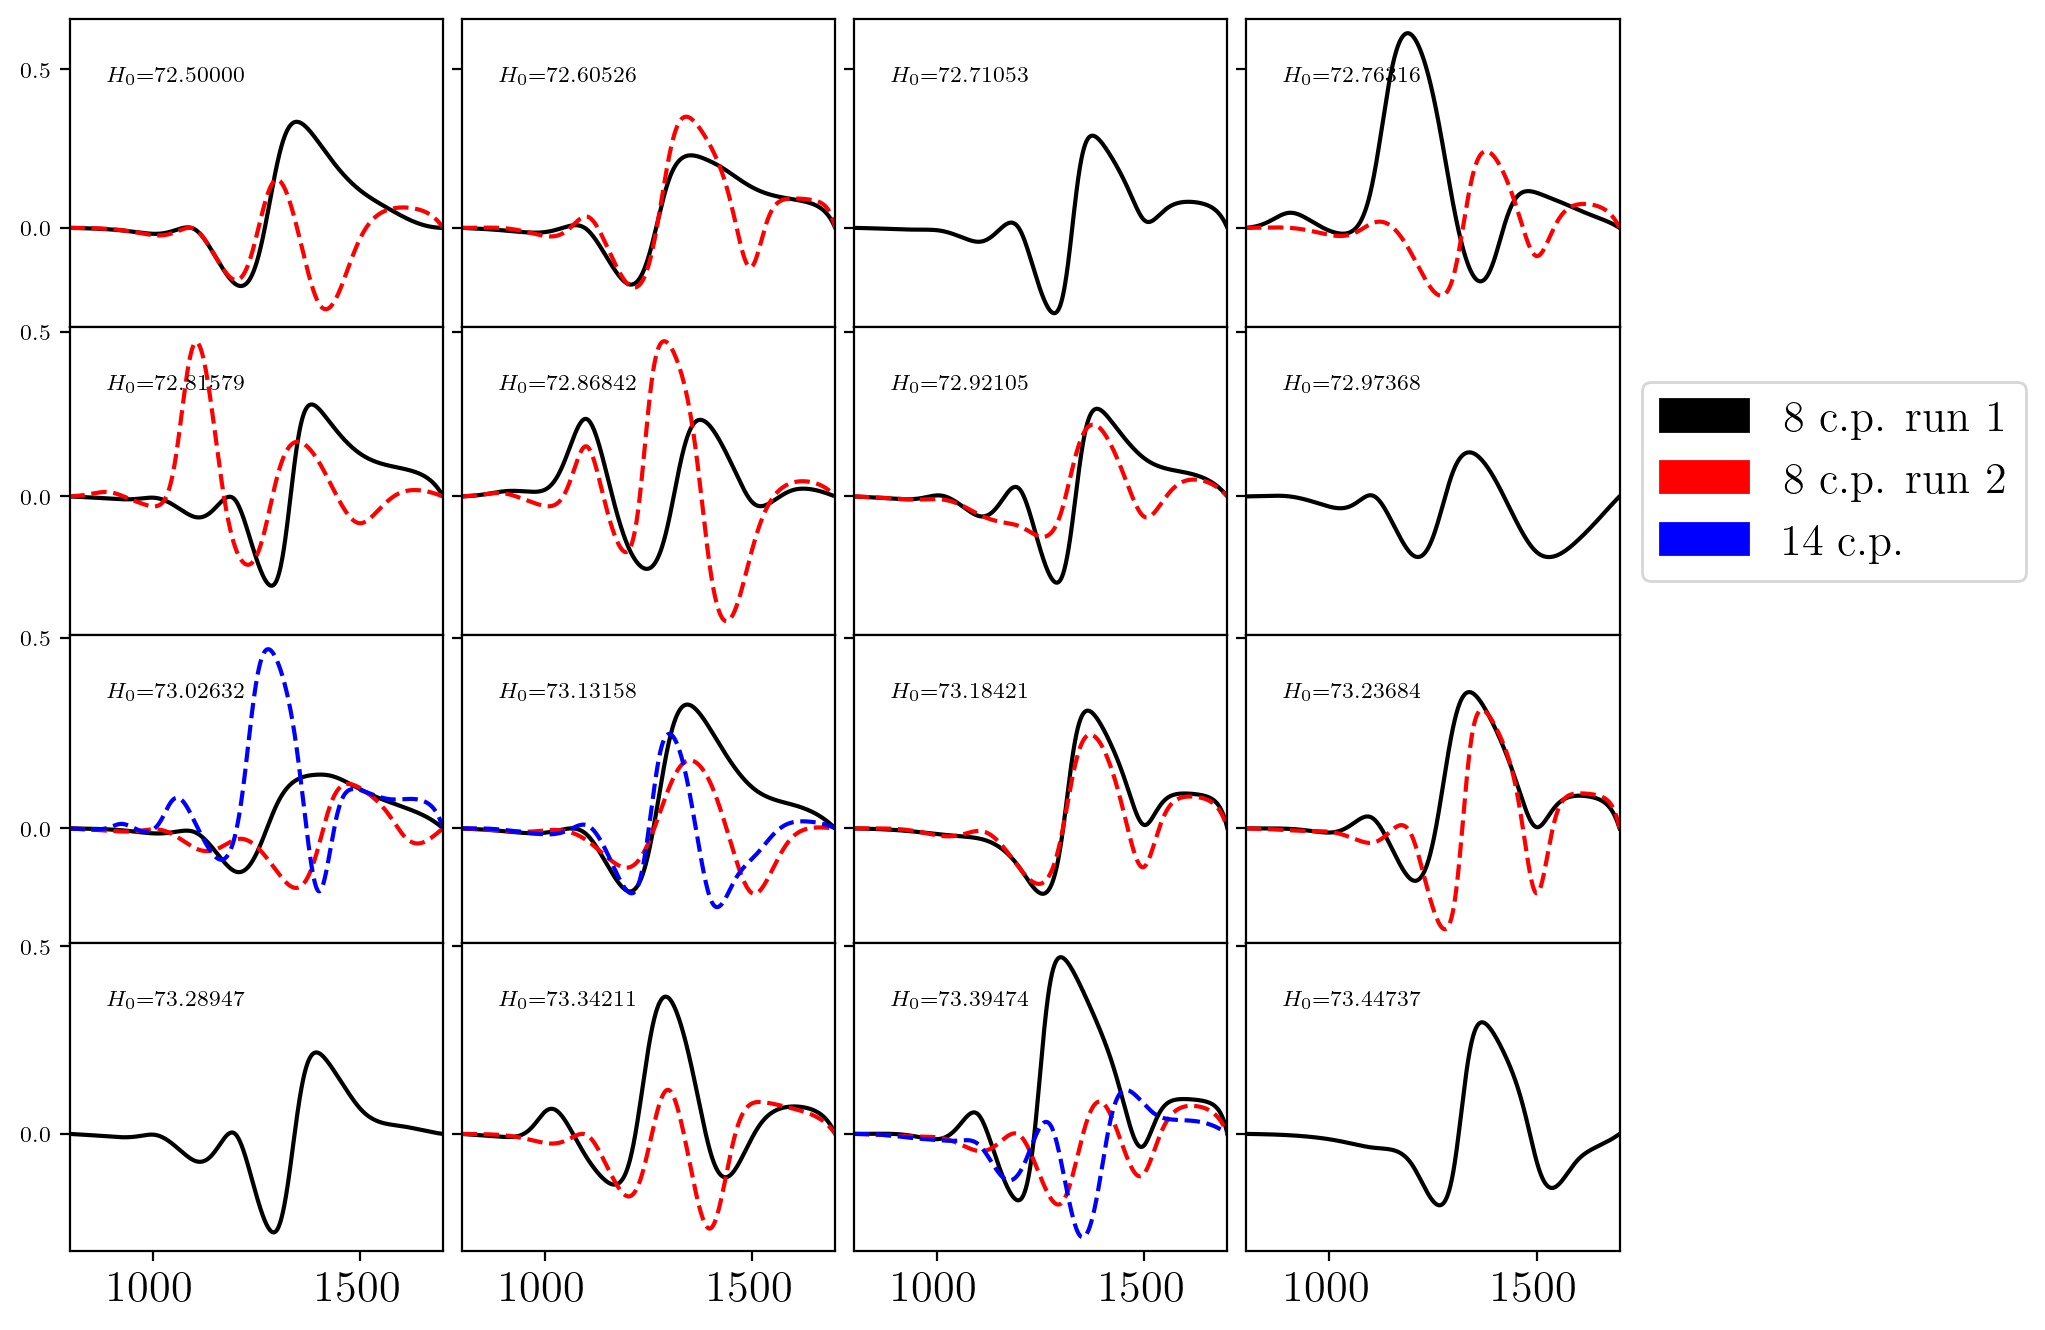

In [13]:
import matplotlib.patches as mpatches

fig,axes = plt.subplots(4,4, figsize=(10, 8), sharex='col', sharey="row")
fig.subplots_adjust(hspace=0.0, wspace=0.05)

thermos_to_plot = [t1, t2, t3]
colors = ["black", "red", "blue"]
styles = ["solid", "dashed", "dashed"]
labels = ["8 c.p. run 1", "8 c.p. run 2", "14 c.p."]

black_patch = mpatches.Patch(color='black', label='8 c.p. run 1')
red_patch = mpatches.Patch(color='red', label='8 c.p. run 2')
blue_patch = mpatches.Patch(color='blue', label='14 c.p.')

for i, thermo in enumerate(thermos_to_plot):
    for j,ax in enumerate(axes.flatten()):
        if(H0s[j] in thermo.keys()):
            ax.plot(thermo[H0s[j]]["z"], thermo[H0s[j]]["xe_pert"], color=colors[i], linestyle=styles[i])

        ax.set_xlim([zmin_pert, zmax_pert])
        ax.locator_params(axis='y', nbins=2)
        ax.tick_params(axis='y', labelsize=8)

for j,ax in enumerate(axes.flatten()):
    ax.text(0.1, 0.8, "$H_0$={0:.5f}".format(100*H0s[j]), fontsize=8, transform=ax.transAxes)

axes[1,3].legend(handles=[black_patch, red_patch, blue_patch], loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig("../results/nldr_mode_zoo.png", dpi=300, bbox_inches='tight')
plt.show()

h=0.7276315789473684 has chi2 of 41601.88505180965
h=0.7286842105263158 has chi2 of 28068.148178145093
h=0.733421052631579 has chi2 of 13043.937699420054


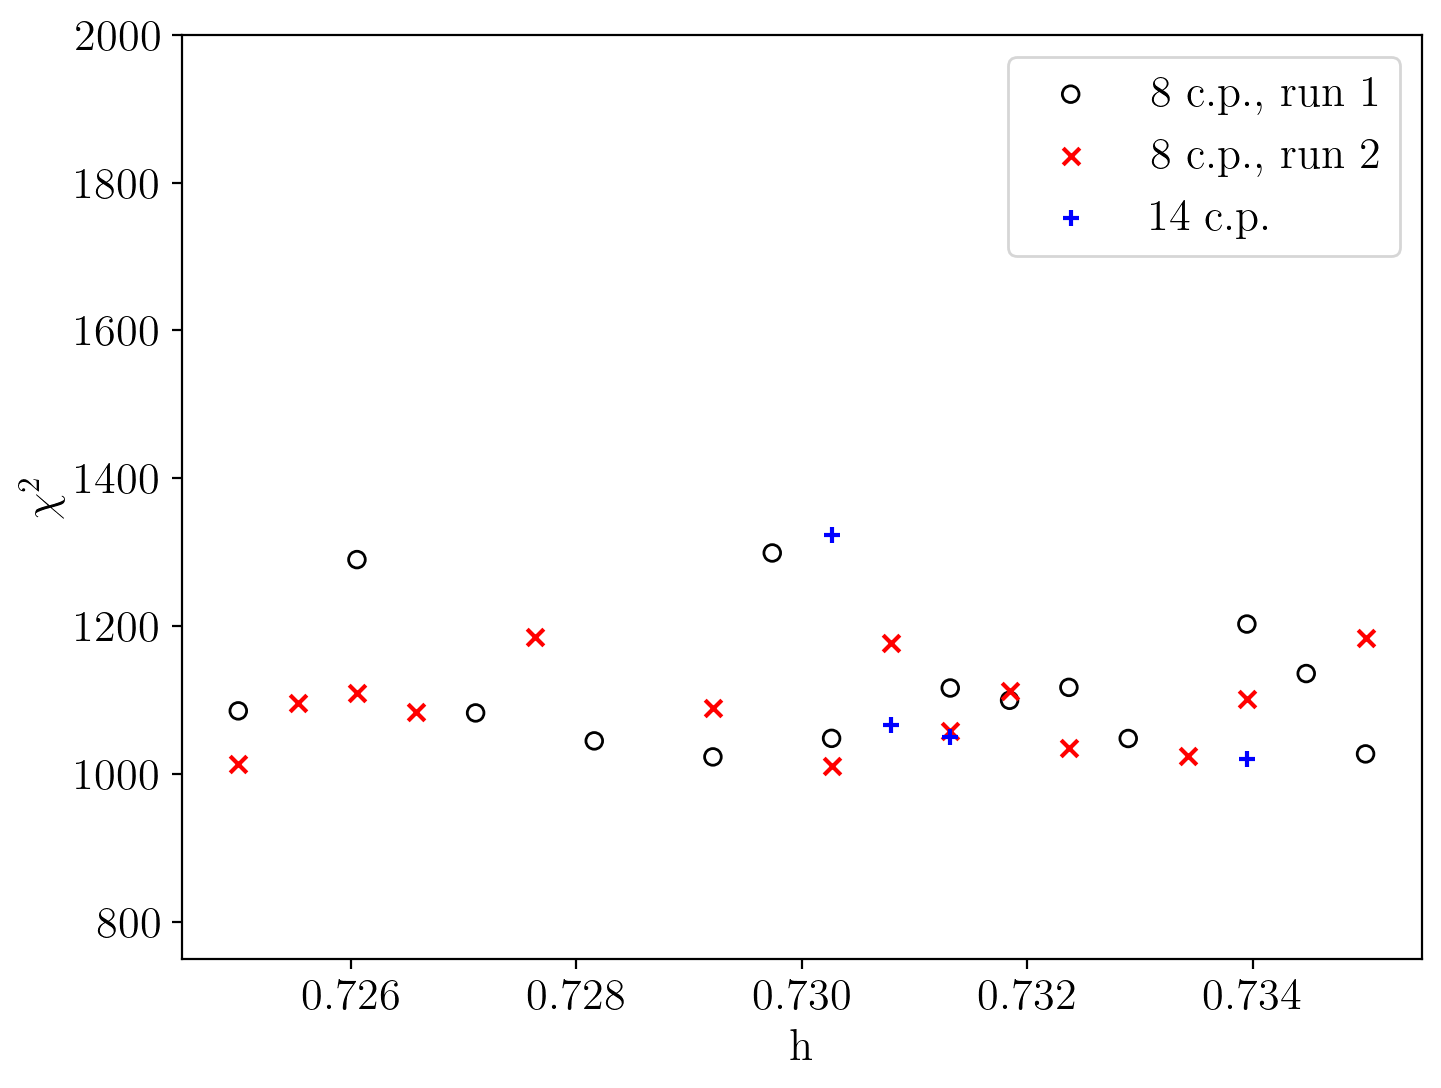

In [14]:
def compute_chi2(df):
    chi2 = {}
    for i,row in df.iterrows():
        #for name in df.columns:
        #    if name.startswith("chi2__CMB"):
        #        running_sum+=row[name]
        chi2[float(row["h"])]= row["chi2__CMB"]
    
    return chi2

fig,ax = plt.subplots()

chi_sq1 = compute_chi2(df1)
chi_sq2 = compute_chi2(df2)
chi_sq3 = compute_chi2(df3)

for h, chi in chi_sq1.items():
    if(chi>4000):
        print("h={} has chi2 of {}".format(h, chi))

ax.scatter(chi_sq1.keys(), chi_sq1.values(), marker="o", facecolors="none", edgecolors="black", label="8 c.p., run 1")
ax.scatter(chi_sq2.keys(), chi_sq2.values(), marker="x", color="red", label="8 c.p., run 2")
ax.scatter(chi_sq3.keys(), chi_sq3.values(), marker="+", color="blue", label="14 c.p.")
ax.set_xlabel("h")
ax.set_ylim([750, 2000])
ax.set_ylabel("$\chi^2$")
plt.legend()

#plt.savefig("../results/nldr_mode_chi2.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print(chi_sq1.values())
print(chi_sq2.values())
print(chi_sq3.values())

dict_values([1085.320987983665, 1289.9405818317173, 1082.531379192984, 41601.88505180965, 1044.7036611357, 28068.148178145093, 1023.0360660861204, 1298.911064851079, 1048.1269595512874, 1116.241113385592, 1099.6159494713845, 1117.1084954177118, 1047.9294011767504, 13043.937699420054, 1202.7612730255014, 1135.7815417047689, 1027.0801220435262])
dict_values([1013.1815603349104, 1095.2785978204602, 1109.6659447575826, 1084.2931204491315, 1184.6015499689313, 25448.15351619157, 11919.173508985608, 1089.3585964404465, 1010.5175583282994, 1177.2780071834748, 1058.0614935811902, 1112.7551304011167, 1034.6103849472768, 1024.0882890304122, 1101.679592205351, 1184.062293560166])
dict_values([1323.5783340890519, 1066.085033106549, 1049.332972975501, 1019.5468147955304])


In [26]:
chi2_cutoff = 1030
chi_sq1_reduced = {key:value for key,value in chi_sq1.items() if value<=chi2_cutoff}
chi_sq2_reduced = {key:value for key,value in chi_sq2.items() if value<=chi2_cutoff}
chi_sq3_reduced = {key:value for key,value in chi_sq3.items() if value<=chi2_cutoff}
print(len(chi_sq1_reduced))
print(len(chi_sq2_reduced))
print(len(chi_sq3_reduced))

2
3
1


1010.5175583282994
1027.0801220435262


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_96008/1203117197.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


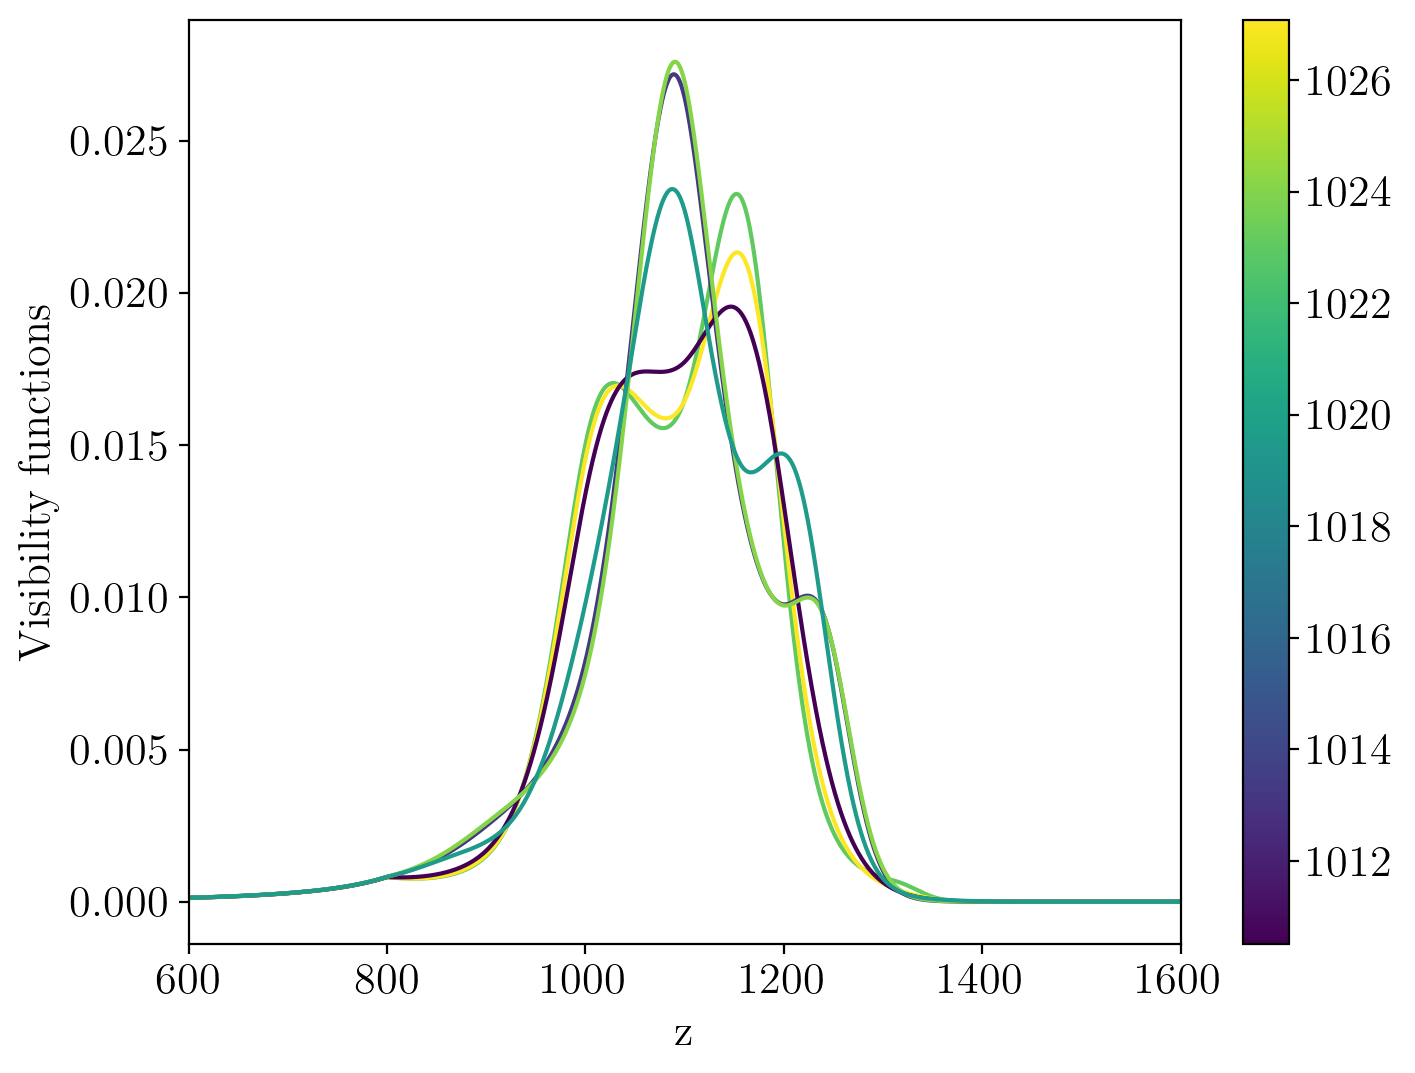

In [33]:
fig,ax=plt.subplots()
cut_dicts = [chi_sq1_reduced, chi_sq2_reduced, chi_sq3_reduced]
thermos = [t1, t2, t3]
colors = ["black", "red", "blue"]
styles = ["solid", "dashed", "dashed"]

minchi = 10000
maxchi = 0

for d in cut_dicts:
    for v in d.values():
        if v<minchi:
            minchi=v 
        elif v>maxchi:
            maxchi=v

print(minchi)
print(maxchi)

norm = mpl.colors.Normalize(vmin=minchi, vmax=maxchi)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

for i,d in enumerate(cut_dicts):
    for h, chi in d.items():
        ax.plot(thermos[i][h]["z"], thermos[i][h]["kappa' [Mpc^-1]"]*thermos[i][h]["exp(-kappa)"], color=cmap.to_rgba(chi))

#ax.plot(fiducial_thermo["z"], fiducial_thermo["kappa' [Mpc^-1]"]*fiducial_thermo["exp(-kappa)"], color="red", linewidth=3)
ax.set_xlim([600, 1600])
ax.set_xlabel("z")
ax.set_ylabel("Visibility functions")
fig.colorbar(cmap)
plt.show()